In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


In [14]:
#Importando e separando os dados

df = pd.read_csv("cleanned_data.csv")
date = df.Date.values

daily_death = df.mortes.values
daily_death_v = df.mortes_vacinados.values

daily_cases = df.casos.values
daily_cases_v = df.infectados_vacinados.values

daily_hosp = df.hospitalizados.values
daily_hosp_v = df.hospitalizados_vacinados.values

vac = np.diff(df.vacinados.values)


#Aplicando a média móvel de 7 dias

def media_movel(arr, janela):
    return np.convolve(arr, np.ones(janela) / janela, mode='valid')

daily_cases = media_movel(daily_cases,7)
daily_cases_v = media_movel(daily_cases_v,7)
daily_death = media_movel(daily_death,7)
daily_death_v = media_movel(daily_death_v,7)
daily_hosp = media_movel(daily_hosp,7)
daily_hosp_v = media_movel(daily_hosp_v,7)

#CORTANDO OS DADOS

#Dados para o fitting no período 02/04/2020:27/10/2020
daily_cases_1 = daily_cases[0:200]
daily_death_1 = daily_death[0:200]
daily_hosp_1 = daily_hosp[0:200]

#Dados para o fitting no período 28/10/2020:17/01/2021
daily_cases_2 = daily_cases[200:282]
daily_death_2  = daily_death[200:282]
daily_hosp_2 = daily_hosp[200:282]

daily_cases_3 = daily_cases[282:530]
daily_death_3  = daily_death[282:530]
daily_hosp_3 = daily_hosp[282: 530]
daily_casesv_3 = daily_cases_v[282:530]
daily_deathv_3  = daily_death_v[282:530]
daily_hospv_3 = daily_hosp_v[282: 530]
vac = vac[282: 531]

rt0 = np.cumsum(daily_cases[0:282])[-1]  #Recuperados totais
dt0 = np.cumsum(daily_death[0:282])[-1] #Mortos totais
ht0 = np.cumsum(daily_hosp[0:282])[-1] #Hospitalizados totais
i0 = daily_cases_3[0]
h0 = daily_hosp_3[0]
d0 = daily_death_3[0]

len(vac)

249

### Fitting do modelo

#### Modelo 2020

In [15]:
N = 14136417
def model_2021(t, y,args):
    
    
    b0, b1, b2, b3, t1, t2, t3, delta, delta_sv, delta_av, k, k_v, h, h_v, p, p_v, gamma_h, gamma_hv, mu_h, mu_hv, eps = args
    
    if t <= t1:
        beta = b0
    elif t1< t <= t2:
        beta = b1
    elif t2 < t <= t3:
        beta = b2
    else:
        beta = b3
        
    # #parâmetros fixos
    gamma_s = 1/4
    gamma_a = 1/3.5
    
    phi = 1/7

    gamma_av = 1/3.5
    gamma_sv = 1/4


    
    S, E, V, Sv, Ev, Ia, Is, Iav, Isv, H, Hv, R, D, Dv, C, CV, Nh, CHv = y
    
    
    tau = vac[int(t)]
    
    #suscetíveis e latentes
    dSdt = -beta*S*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)/N - tau
    dVdt = tau - phi*V 
    dEdt = beta*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)*S/N - k*E
    dSvdt =  phi*V - (1-eps)*beta*Sv*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)/N
    dEvdt = ((1-eps)*beta*Sv*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv))/N - k_v*Ev
    
    #infectados
    dIadt = (1-p)*k*E - gamma_a*Ia
    dIsdt = p*k*E - gamma_s*Is
    dHdt = h*gamma_s*Is - gamma_h*H - mu_h*H
    
    #infectados vacinados
    dIavdt = (1-p_v)*k_v*Ev - gamma_av*Iav
    dIsvdt = p_v*k_v*Ev - gamma_sv*Isv
    dHvdt = h_v*gamma_sv*Isv - gamma_hv*Hv - mu_hv*Hv
    
    #recuperados
    dRdt = gamma_a*Ia + gamma_av*Iav + (1-h)*gamma_s*Is + (1-h_v)*gamma_sv*Isv + gamma_h*H + gamma_hv*Hv
    
    #Óbitos
    dDdt = mu_h*H
    dDvdt = mu_hv*Hv
    
    #Curvas de crescimento
    dCdt = p*k*E #infectados sintomáticos
    dNHdt = h*gamma_s*Is #hospitalizados
    dCHVdt = h_v*gamma_sv*Isv #hospitalizados vacinados
    dCVdt = p_v*k_v*Ev #infectados vacinados
    
    return [dSdt, dEdt, dVdt, dSvdt, dEvdt, dIadt, dIsdt, dIavdt, dIsvdt, dHdt, 
            dHvdt,dRdt, dDdt, dDvdt, dCdt, dCVdt, dNHdt, dCHVdt]

In [16]:
theta = [1.99244967e+00, 8.78738116e-01, 1.17515411e+00, 1.21895834e+00,
 1.65460217e+01, 8.11004329e+01, 1.61788078e+02, 1.02280196e-01,
 3.25357744e-01, 3.31891562e-01, 3.21667509e-01, 3.26233291e-01,
 7.70364297e-02, 1.04783344e-01 ,2.27568095e-01, 7.49050949e-01,
 1.88894374e-01, 1.45739368e-01, 7.68962258e-02, 9.68245351e-02,
 7.74258049e-01, 1.05590320e+03, 1.15729415e+03]

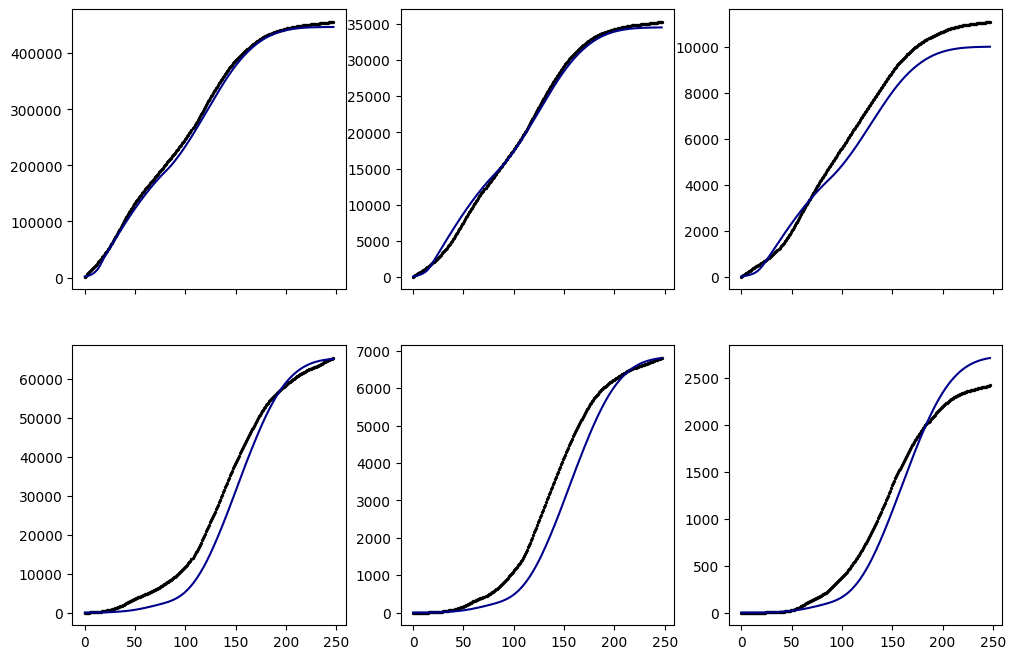

In [17]:
b0, b1, b2, b3, t1, t2, t3, delta, delta_sv, delta_av, k, k_v, h, h_v, p, p_v, gamma_h, gamma_hv, mu_h, mu_hv, eps, e0,ia0 = theta


params =  b0, b1, b2, b3, t1, t2, t3, delta, delta_sv, delta_av, k, k_v, h, h_v, p, p_v, gamma_h, gamma_hv, mu_h, mu_hv, eps
sol = solve_ivp(fun = model_2021, t_span = [0, len(daily_cases_3)], args=(params,),
                y0=[N-e0-ia0-i0-rt0-dt0-ht0-h0, e0, 0, 0, 0, ia0, i0, 0, 0, h0, 0, rt0, d0,0, i0, 0, h0, 0],
                t_eval = np.arange(len(daily_cases_3)))



daily_cases_3 = daily_cases[282:530]
daily_death_3  = daily_death[282:530]
daily_hosp_3 = daily_hosp[282: 530]
daily_casesv_3 = daily_cases_v[282:530]
daily_deathv_3  = daily_death_v[282:530]
daily_hospv_3 = daily_hosp_v[282: 530]

data = [daily_death_3,daily_deathv_3,daily_cases_3,daily_casesv_3,daily_hosp_3,daily_hospv_3]

fig, ax = plt.subplots(2,3,figsize = (12,8), sharex = True)



ax[0][0].plot(np.arange(len(sol.y[-4])),sol.y[-4], color='darkblue',)
ax[0][0].scatter(np.arange(len(sol.y[-4])),np.cumsum(daily_cases_3), s=2, color='k',)

ax[1][0].plot(np.arange(len(sol.y[-4])),sol.y[-3], color='darkblue',)
ax[1][0].scatter(np.arange(len(sol.y[-4])),np.cumsum(daily_casesv_3), s=2, color='k',)



ax[0][1].plot(np.arange(len(sol.y[-4])),sol.y[-2], color='darkblue',)
ax[0][1].scatter(np.arange(len(sol.y[-4])),np.cumsum(daily_hosp_3), s=2, color='k',)

ax[1][1].plot(np.arange(len(sol.y[-4])),sol.y[-1], color='darkblue',)
ax[1][1].scatter(np.arange(len(sol.y[-4])),np.cumsum(daily_hospv_3), s=2, color='k',)



ax[0][2].plot(np.arange(len(sol.y[-4])),sol.y[-6], color='darkblue',)
ax[0][2].scatter(np.arange(len(sol.y[-4])),np.cumsum(daily_death_3), s=2, color='k',)

ax[1][2].plot(np.arange(len(sol.y[-4])),sol.y[-5], color='darkblue',)
ax[1][2].scatter(np.arange(len(sol.y[-4])),np.cumsum(daily_deathv_3), s=2, color='k',)



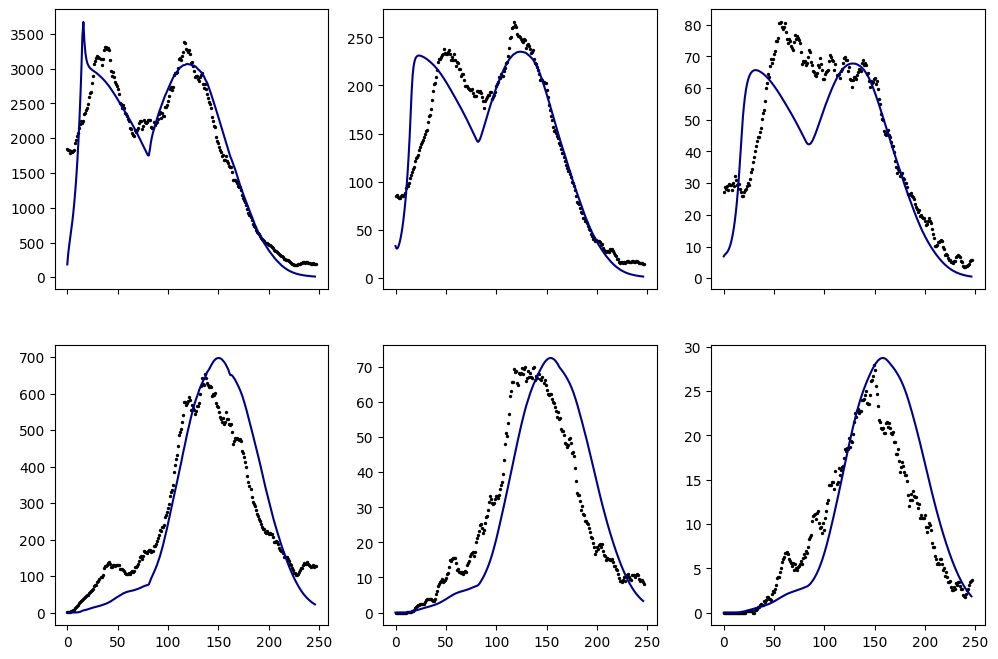

In [25]:
b0, b1, b2, b3, t1, t2, t3, delta, delta_sv, delta_av, k, k_v, h, h_v, p, p_v, gamma_h, gamma_hv, mu_h, mu_hv, eps, e0,ia0 = theta


params =  b0, b1, b2, b3, t1, t2, t3, delta, delta_sv, delta_av, k, k_v, h, h_v, p, p_v, gamma_h, gamma_hv, mu_h, mu_hv, eps
sol = solve_ivp(fun = model_2021, t_span = [0, len(daily_cases_3)], args=(params,),
                y0=[N-e0-ia0-i0-rt0-dt0-ht0-h0, e0, 0, 0, 0, ia0, i0, 0, 0, h0, 0, rt0, d0,0, i0, 0, h0, 0],
                t_eval = np.arange(len(daily_cases_3)))



daily_cases_3 = daily_cases[282:530]
daily_death_3  = daily_death[282:530]
daily_hosp_3 = daily_hosp[282: 530]
daily_casesv_3 = daily_cases_v[282:530]
daily_deathv_3  = daily_death_v[282:530]
daily_hospv_3 = daily_hosp_v[282: 530]

data = [daily_death_3,daily_deathv_3,daily_cases_3,daily_casesv_3,daily_hosp_3,daily_hospv_3]

fig, ax = plt.subplots(2,3,figsize = (12,8), sharex = True)



ax[0][0].plot(np.arange(len(sol.y[-4])-1),np.diff(sol.y[-4]), color='darkblue',)
ax[0][0].scatter(np.arange(len(sol.y[-4])),(daily_cases_3), s=2, color='k',)

ax[1][0].plot(np.arange(len(sol.y[-4])-1),np.diff(sol.y[-3]), color='darkblue',)
ax[1][0].scatter(np.arange(len(sol.y[-4])),(daily_casesv_3), s=2, color='k',)



ax[0][1].plot(np.arange(len(sol.y[-4])-1),np.diff(sol.y[-2]), color='darkblue',)
ax[0][1].scatter(np.arange(len(sol.y[-4])),(daily_hosp_3), s=2, color='k',)

ax[1][1].plot(np.arange(len(sol.y[-4])-1),np.diff(sol.y[-1]), color='darkblue',)
ax[1][1].scatter(np.arange(len(sol.y[-4])),(daily_hospv_3), s=2, color='k',)



ax[0][2].plot(np.arange(len(sol.y[-4])-1),np.diff(sol.y[-6]), color='darkblue',)
ax[0][2].scatter(np.arange(len(sol.y[-4])),(daily_death_3), s=2, color='k',)

ax[1][2].plot(np.arange(len(sol.y[-4])-1),np.diff(sol.y[-5]), color='darkblue',)
ax[1][2].scatter(np.arange(len(sol.y[-4])),(daily_deathv_3), s=2, color='k',)

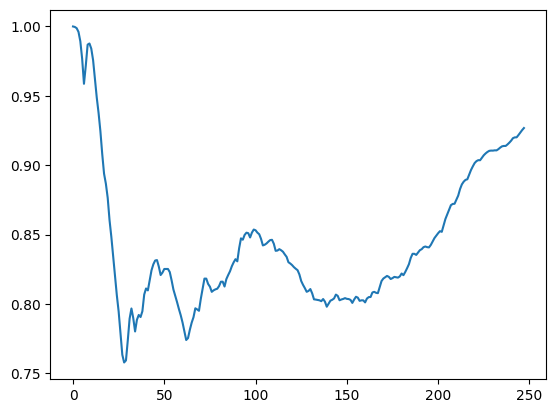

In [57]:
casesv = sol.y[-3]
cases = sol.y[-4]
incidence_v = np.zeros(len(daily_deathv_3))
incidence = np.zeros(len(daily_deathv_3))
cumu_vac0 = df.vacinados.values
cumu_vac = cumu_vac0[282:282+len(daily_deathv_3) ]
for i in np.arange(len(daily_deathv_3)):
    incidence_v[i] = casesv[i]/cumu_vac[i]
    incidence[i] = cases[i]/(N-cumu_vac[i])
    
# plt.plot(np.arange(len(incidence)),incidence_v)
# plt.plot(np.arange(len(incidence)),incidence)
plt.plot(np.arange(len(incidence)),1-incidence_v/incidence)




##### Parâmetros 2020

In [19]:
# intervals = np.array(   [ 
#                          [0, 2.], # b0
#                          [0, 2.], # b1
#                          [0, 2.], # b2
#                          [0, 2.], # b3
#                          [0, 50], # t1
#                          [50, 70], # t2
#                          [75,150], # t3
#                          [0.1, 0.75], # delta
#                          [0.1, 0.75], # delta_sv
#                          [0.1, 0.75], # delta_av
#                          [1/6, 1/5], # k
#                          [1/6, 1/5], # k_v
#                          [0.05, 0.25], # h
#                          [0.05, 0.25], # h_v
#                          [0.1, 0.5], # p
#                          [0.1, 0.8], # p_v
#                          [1/15, 1/3], # gamma_h
#                          [1/15, 1/3], # gamma_hv
#                          [0.05, 0.3], # mu_h
#                          [0.05, 0.3], # mu_hv
#                          [0.5,0.9], #eps
#                          [200,2000], # e0
#                          [500,3000]#ia0
                         
#                        ])

# def lnprior(theta):
#     b0, b1, b2, b3, t1, t2, t3, delta, delta_sv, delta_av, k, k_v, h, h_v, p, p_v, gamma_h, gamma_hv, mu_h, mu_hv, eps, e0, ia0= theta

#     if (    intervals[0,0] < b0     < intervals[0,1]  and 
#             intervals[1,0] < b1     < intervals[1,1]  and 
#             intervals[2,0] < b2     < intervals[2,1]  and 
#             intervals[3,0] < b3  < intervals[3,1]  and 
#             intervals[4,0] < t1      < intervals[4,1]  and 
#             intervals[5,0] < t2     < intervals[5,1]  and 
#             intervals[6,0] < t3     < intervals[6,1]  and 
#             intervals[7,0] < delta     < intervals[7,1]  and 
#             intervals[8,0] < delta_sv     < intervals[8,1]  and 
#             intervals[9,0] < delta_av     < intervals[9,1]  and 
#             intervals[10,0] < k   < intervals[10,1] and 
#             intervals[11,0] < k_v   < intervals[11,1] and 
#             intervals[12,0] < h   < intervals[12,1] and 
#             intervals[13,0] < h_v   < intervals[13,1] and 
#             intervals[14,0] < p   < intervals[14,1] and 
#             intervals[15,0] < p_v   < intervals[15,1] and 
#             intervals[16,0] < gamma_h   < intervals[16,1] and 
#             intervals[17,0] < gamma_hv   < intervals[17,1] and 
#             intervals[18,0] < mu_h   < intervals[18,1] and 
#             intervals[19,0] < mu_hv   < intervals[19,1] and 
#             intervals[20,0] < eps   < intervals[20,1] and 
#             intervals[21,0] < e0   < intervals[21,1]  and
#             intervals[22,0] < ia0   < intervals[22,1] 
            
#                 ):
#         return 0.0
#     return -np.inf

# def model(theta):
#     b0, b1, b2, b3, t1, t2, t3, delta, delta_sv, delta_av, k, k_v, h, h_v, p, p_v, gamma_h, gamma_hv, mu_h, mu_hv, eps, e0,ia0 = theta
#     params =  b0, b1, b2, b3, t1, t2, t3, delta, delta_sv, delta_av, k, k_v, h, h_v, p, p_v, gamma_h, gamma_hv, mu_h, mu_hv, eps
#     sol = solve_ivp(fun = model_2021, t_span = [0, len(daily_cases_3)], args=(params,),
#                     y0=[N-e0-ia0-i0-rt0-dt0-ht0-h0, e0, 0, 0, 0, ia0, i0, 0, 0, h0, 0, rt0, d0,0, i0, 0, h0, 0],
#                     t_eval = np.arange(len(daily_cases_3)))


    
#     dailycasos_model =  (sol.y[-4,:]).astype(float)
#     dailymortes_model = (sol.y[-6,:]).astype(float)
#     dailyhosp_model =   (sol.y[-2,:]).astype(float)
#     dailyhospv_model = (sol.y[-1,:]).astype(float)
#     dailymortesv_model = (sol.y[-5,:]).astype(float)
#     dailycasosv_model = (sol.y[-3,:]).astype(float)


#     return np.r_[dailycasos_model,dailymortes_model,dailyhosp_model,dailycasosv_model,dailymortesv_model,dailyhospv_model]

# def lnlike(theta):
    
#     cases = np.cumsum(daily_cases_3)
#     death = np.cumsum(daily_death_3)
#     hosp = np.cumsum(daily_hosp_3)
#     casesv = np.cumsum(daily_casesv_3)
#     deathv = np.cumsum(daily_deathv_3)
#     hospv = np.cumsum(daily_hospv_3)
    
#     y_data = np.r_[cases, death, hosp, casesv, deathv, hospv]
#     model_results = model(theta)

#     return -0.5 * np.sum(((y_data - model_results)/0.05) ** 2)
    

# def lnprob(theta):
#     lp = lnprior(theta)
#     if not np.isfinite(lp):
#         return -np.inf
#     return lp + lnlike(theta)


# def main(p0,nwalkers,niter,ndim,lnprob):
#     sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

#     print("Running burn-in...")
#     p0, _, _ = sampler.run_mcmc(p0, 100)
#     sampler.reset()

#     print("Running production...")
#     pos, prob, state = sampler.run_mcmc(p0, niter,progress=True)

#     return sampler, pos, prob, state


# parametros=[]


# nwalkers = 1000
# niter = 6000



# par0 = np.random.rand(len(intervals))
# initial = intervals[:,0] + par0 * (intervals[:,1] - intervals[:,0])
# ndim = len(initial)
# p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

# sampler1, pos1, prob1, state1 = main(p0,nwalkers,niter,ndim,lnprob)
# samples = sampler1.flatchain
# theta_max = samples[np.argmax(sampler1.flatlnprobability)]
# parametros.append([theta_max])



# name1 = './resultados/params_3.txt'

# # Escrevendo a lista de listas no arquivo CSV
# with open(name1, mode='w', newline='', encoding='utf-8') as arquivo_csv:
#     escritor_csv = csv.writer(arquivo_csv)
#     # Escrevendo as linhas da lista de listas
#     escritor_csv.writerows(parametros)

# print(f"Dados salvos em {name1}")


In [20]:
# b0, b1, b2, b3, t1, t2, t3, delta, delta_sv, delta_av, k, k_v, h, h_v, p, p_v, gamma_h, gamma_hv, mu_h, mu_hv, eps, e0,ia0 = theta
# params =  b0, b1, b2, b3, t1, t2, t3, delta, delta_sv, delta_av, k, k_v, h, h_v, p, p_v, gamma_h, gamma_hv, mu_h, mu_hv, eps
# sol = solve_ivp(fun = model_2021, t_span = [0, len(daily_cases_3)], args=(params,),
#                 y0=[N-e0-ia0-i0-rt0-dt0-ht0-h0, e0, 0, 0, 0, ia0, i0, 0, 0, h0, 0, rt0, d0,0, i0, 0, h0, 0],
#                 t_eval = np.arange(len(daily_cases_3)))



# dailycasos_model =  (sol.y[-4,:]).astype(float)
# dailymortes_model = (sol.y[-6,:]).astype(float)
# dailyhosp_model =   (sol.y[-2,:]).astype(float)
# dailyhospv_model = (sol.y[-1,:]).astype(float)
# dailymortesv_model = (sol.y[-5,:]).astype(float)
# dailycasosv_model = (sol.y[-3,:]).astype(float)
# a = sol.y[2]

# fig,ax  = plt.subplots(figsize=(8,4))

# ax.plot(np.arange(len(a)),(a), color = 'darkblue')
# # ax.scatter(np.arange(len(a)),np.cumsum(daily_hospv_3), s=1.5, color='k')

# ax.axvline(t1,0,9000, color='red')
# ax.axvline(t2,0,9000, color='red')
# ax.axvline(t3,0,9000, color='red')
# eps

In [21]:
# import os
# import smtplib
# from email.mime.multipart import MIMEMultipart
# from email.mime.base import MIMEBase
# from email.mime.text import MIMEText
# from email import encoders

# def list_files_in_folder(folder_path):
#     """
#     Function to list all files in a given folder.
#     """
#     files = []
#     for filename in os.listdir(folder_path):
#         file_path = os.path.join(folder_path, filename)
#         if os.path.isfile(file_path):
#             files.append(file_path)
#     return files

# def send_email_with_attachments(sender_email, receiver_email, subject, body, folder_path, smtp_server, smtp_port, login, password):
#     """
#     Function to send an email with attachments from a folder.
#     """
#     # Create the email
#     msg = MIMEMultipart()
#     msg['From'] = sender_email
#     msg['To'] = receiver_email
#     msg['Subject'] = subject
#     msg.attach(MIMEText(body, 'plain'))

#     # Get the list of files in the folder
#     files = list_files_in_folder(folder_path)

#     # Attach each file to the email
#     for file in files:
#         with open(file, "rb") as attachment:
#             part = MIMEBase('application', 'octet-stream')
#             part.set_payload(attachment.read())
#             encoders.encode_base64(part)
#             part.add_header('Content-Disposition', f'attachment; filename="{os.path.basename(file)}"')
#             msg.attach(part)

#     # Connect to the server and send the email
#     with smtplib.SMTP(smtp_server, smtp_port) as server:
#         server.starttls()
#         server.login(login, password)
#         server.sendmail(sender_email, receiver_email, msg.as_string())

# # Example usage
# folder_path = './resultados'  # Replace with your folder path
# sender_email = 'filipe.cruz.ribeiro@gmail.com'
# receiver_email = 'filipecr@ufba.br'
# subject = 'ARQUIVOS DO FIT'
# body = 'Please find the attached files.'
# smtp_server = 'smtp.gmail.com'  # For Gmail, change for other services
# smtp_port = 587
# login = 'filipe.cruz.ribeiro@gmail.com'
# password = 'dbuq yhwb kvcj poah'

# # Call the function to send the email
# send_email_with_attachments(sender_email, receiver_email, subject, body, folder_path, smtp_server, smtp_port, login, password)
# receiver_email = 'robertgabriel2112@gmail.com'
# send_email_with_attachments(sender_email, receiver_email, subject, body, folder_path, smtp_server, smtp_port, login, password)

In [22]:
# cases_cumu = np.cumsum(daily_cases_3)
# death_cumu = np.cumsum(daily_death_3)
# hosp_cumu = np.cumsum(daily_hosp_3)
# casesv_cumu = np.cumsum(daily_casesv_3)
# deathv_cumu = np.cumsum(daily_deathv_3)
# hospv_cumu = np.cumsum(daily_hospv_3)

# cases = daily_cases_3[1:]
# death = daily_death_3[1:]
# hosp = daily_hosp_3[1:]
# casesv = daily_casesv_3[1:]
# deathv = daily_deathv_3[1:]
# hospv = daily_hospv_3[1:]

# y_data = np.r_[cases_cumu, death_cumu, hosp_cumu, casesv_cumu, deathv_cumu, hospv_cumu,cases, death, hosp, casesv, deathv, hospv]


# a = model(parametros[0][0])
# plt.plot(np.arange(len(a)),a)
# plt.scatter(np.arange(len(a)),y_data,s=1,color='k')
# len(a)

In [23]:


# for j in [0,1,2]:

#     size = 150
#     b0, b1, t1, delta, k, h, p, gamma_h, mu_h, i0 = par[j]

#     params =  b0, b1, t1, delta, k, h, p, gamma_h, mu_h


#     sol = solve_ivp(model_2020, [0, size], [N-i0,0,0,0,0,0,i0,0,0,0,0,0,0,i0,0,0,0], args = (params,),
#                     dense_output=True, t_eval =np.arange(size))


#     fig, ax = plt.subplots(2,3,figsize = (12,6),sharex = True,layout='constrained')

#     ax[0][0].plot(np.arange(len(sol.y[-4])-1),np.diff(sol.y[-4]), color = 'darkblue')
#     ax[0][0].scatter(np.arange(size),(daily_cases[:size]), s=1, color='k')
#     ax[0][0].set_title('Casos')
#     ax[1][0].plot(np.arange(len(sol.y[-4])),(sol.y[-4]), color = 'darkblue')
#     ax[1][0].scatter(np.arange(size),np.cumsum(daily_cases[:size]), s=1, color='k')

#     ax[0][1].plot(np.arange(len(sol.y[-4])-1),np.diff(sol.y[-3]), color = 'darkblue')
#     ax[0][1].scatter(np.arange(size),(daily_hosp[:size]), s=1, color='k')
#     ax[0][1].set_title('Hospitalizados')

#     ax[1][1].plot(np.arange(len(sol.y[-4])),(sol.y[-3]), color = 'darkblue')
#     ax[1][1].scatter(np.arange(size),np.cumsum(daily_hosp[:size]), s=1, color='k')

#     ax[0][2].plot(np.arange(len(sol.y[-4])-1),np.diff(sol.y[-5]), color = 'darkblue')
#     ax[0][2].scatter(np.arange(size),(daily_death[:size]), s=1, color='k')
#     ax[0][2].set_title('Mortes')

#     ax[1][2].plot(np.arange(len(sol.y[-4])),(sol.y[-5]), color = 'darkblue')
#     ax[1][2].scatter(np.arange(size),np.cumsum(daily_death[:size]), s=1, color='k')



#     for i in [0,1]:
#         if i == 0: lim = 50
#         else: lim = 4000
#         ax[i][0].axvline(t1,0,4500, color = 'k', linestyle = '--')
#         ax[i][1].axvline(t1,0,4500, color = 'k', linestyle = '--')
#         ax[i][2].axvline(t1,0,4500, color = 'k', linestyle = '--')


  
#     fig.savefig ("Figs\\Fitting 2020 range " +time[j]+".png")

    
    
    
    
    
    
    
    
    

In [24]:
# lim_inf = 0
# lim_sup = 500
# ts = np.arange(len(date[lim_inf:lim_sup]))

# fig,axs = plt.subplots(3,figsize = (8,8),sharex = True)

# axs[0].scatter(date[lim_inf:lim_sup],daily_death[lim_inf:lim_sup],color='k',s=1)
# axs[1].scatter(date[lim_inf:lim_sup],daily_hosp[lim_inf:lim_sup],color='k',s=1)
# axs[2].scatter(date[lim_inf:lim_sup], daily_cases[lim_inf:lim_sup],color='k',s=1)
# axs[2].plot(np.arange(len(sol.y[-4][0:200])-1),np.diff(sol.y[-4][0:200]), color = 'darkblue',label = 'Fitting')
# axs[1].plot(np.arange(len(sol.y[-4][0:200])-1),np.diff(sol.y[-3][0:200]), color = 'darkblue',label = 'Fitting')
# axs[0].plot(np.arange(len(sol.y[-4][0:200])-1),np.diff(sol.y[-5][0:200]), color = 'darkblue',label = 'Fitting')
# y = np.arange(0, 6000, 0.01)


# axs[0].set_title("Daily deaths")
# axs[1].set_title("Daily hospitalizations")
# axs[2].set_title("Daily cases")

# for i in [0,1,2]:
#     axs[i].vlines(282,0,6000, linestyles= '--', color='orange',label = 'Vacinação 1')
#     axs[i].fill_betweenx(y, 169, 215, color = 'gray', alpha = 0.3,label = 'Período eleit.')
#     axs[i].vlines(157,0,6000, linestyles= '--', color='darkgreen',label = 'Artigo')
#     axs[i].vlines(215,0,6000, linestyles= '--', color='darkred',label = 'Eleições')
#     axs[i].vlines(234,0,6000, linestyles= '-.', color='violet',label = 'Var. Gamma')
#     axs[i].vlines(480, 0, 6000, linestyles= '-.', color='purple',label = 'Var. Delta')
#     axs[i].legend(loc = 'best')
#     axs[i].tick_params(labelsize=10,rotation = 45)
#     axs[i].xaxis.set_major_locator(plt.MaxNLocator(20))
    
    
# axs[0].set_ylim(0,(11/10)*max(daily_death[lim_inf:lim_sup]))
# axs[1].set_ylim(0,(11/10)*max(daily_hosp[lim_inf:lim_sup]))
# axs[2].set_ylim(0,(11/10)*max(daily_cases[lim_inf:lim_sup]))
# fig.get_tight_layout()

# fig.savefig('Figs\\Resultado')